In [17]:
import pandas as pd

# Read in your files
csv1 = pd.read_csv('all_mice_GSE64398.csv') 
csv2 = pd.read_csv('same_mouse_human_gene_mapping.csv')
csv3 = pd.read_csv('all_mice_GSE64398_metadata.csv')  # must have 'Accession', 'Age_weeks', 'AD'

# Step 1: Row filtering & reordering as before
csv1['ID_REF'] = csv1['ID_REF'].astype(str)
csv2['gene_id_mouse'] = csv2['gene_id_mouse'].astype(str)
ordered_genes = csv2['gene_id_mouse'].tolist()
csv1_filtered = csv1[csv1['ID_REF'].isin(ordered_genes)]
csv1_filtered = csv1_filtered.set_index('ID_REF')
csv1_matched_order = csv1_filtered.reindex(ordered_genes).reset_index()

# Step 2: Map age & AD for each sample column
# Make sure Accession is string and matches columns
csv3['Accession'] = csv3['Accession'].astype(str)
age_dict = dict(zip(csv3['Accession'], csv3['Age_weeks']))
ad_dict  = dict(zip(csv3['Accession'], csv3['AD']))

# For all columns that start with GSM (samples), build age and AD rows
sample_cols = [col for col in csv1_matched_order.columns if col.startswith('GSM')]

age_row = ['age'] + [age_dict.get(col, '') for col in sample_cols]
ad_row  = ['AD']  + [ad_dict.get(col, '')  for col in sample_cols]

# Append the rows to the DataFrame
df_plus_rows = pd.concat([
    csv1_matched_order,
    pd.DataFrame([age_row, ad_row], columns=csv1_matched_order.columns)
], ignore_index=True)

# Save to file
# df_plus_rows.to_csv('csv1_reordered_with_age_AD.tsv', sep='\t', index=False)

# Preview the result
print(df_plus_rows.tail(5))

      ID_REF GSM1570253 GSM1570254 GSM1570255 GSM1570256 GSM1570257  \
9630  ZYG11B    6.93133    7.13554    6.99881    6.92082    6.81639   
9631     ZYX    12.1803    12.4074    12.2972    12.1735    12.3489   
9632    ZZZ3    6.55961    6.58151    6.71003    6.71477    6.62435   
9633     age         32         16         32         16         72   
9634      AD        yes        yes         no        yes         no   

     GSM1570258 GSM1570259 GSM1570260 GSM1570261  ... GSM1570576 GSM1570577  \
9630    6.41424    7.05888     6.9318      6.808  ...    6.85327    6.84665   
9631    11.9116     12.059    12.1774    12.2862  ...     11.622    11.9337   
9632    6.64601    6.66812    6.57711    6.58633  ...     6.7401    6.57661   
9633         16          8          8         72  ...         72         72   
9634        yes         no        yes        yes  ...         no         no   

     GSM1570578 GSM1570579 GSM1570580 GSM1570581 GSM1570582 GSM1570583  \
9630    6.96314    6.985

In [35]:
import pandas as pd
import numpy as np

# df: original DataFrame (rows = features + metadata, columns = patients)

GENE_ROWS = slice(0, 9633)      # Python slice end is exclusive; row 0..9632
AGE_ROW = 9633
LABEL_ROW = 9634

df = df_plus_rows.copy()

# 1. Split components
gene_expr = df.iloc[GENE_ROWS, :].copy()
age_series = df.iloc[AGE_ROW, :].copy()
label_series = df.iloc[LABEL_ROW, :].copy()

# 2. Ensure numeric gene expression
# Coerce all to numeric; invalid parse becomes NaN
gene_expr = gene_expr.apply(pd.to_numeric, errors='coerce')

# 3. Build a new DataFrame with samples as rows
# Transpose gene expression so rows = patients
X_genes = gene_expr.T  # shape: n_patients x n_genes
X_genes.columns = [f'gene_{i}' for i in range(X_genes.shape[1])]

# Add age
age = pd.to_numeric(age_series, errors='coerce')
X_genes['age'] = age

# Labels: map yes/no (adjust mapping if your dataset uses different terms)
y = label_series.str.strip().str.lower().map({'yes': 1, 'no': 0})

# Combine
data = X_genes.copy()
data['AD'] = y

# Drop samples with missing label or age
data = data.dropna(subset=['AD', 'age'])

print(data.shape)        # (n_patients, n_genes + 2)
print(data['AD'].value_counts())

(333, 9635)
AD
1.0    219
0.0    114
Name: count, dtype: int64


In [34]:
# 1–3 as you already have
gene_expr = df.iloc[GENE_ROWS, :].apply(pd.to_numeric, errors='coerce')
X_genes = gene_expr.T

# Keep only the last 1000 gene features
X_genes = X_genes.iloc[:, -4000:]
X_genes.columns = [f'gene_{i}' for i in range(X_genes.shape[1])]

# Add age
age = pd.to_numeric(age_series, errors='coerce')
X_genes['age'] = age

# Labels
y = label_series.astype(str).str.strip().str.lower().map({'yes': 1, 'no': 0})

# Combine
data = X_genes.copy()
data['AD'] = y

# Drop samples with missing label or age
data = data.dropna(subset=['AD', 'age'])

print(data.shape)        # (n_patients, 1000 + 2)
print(data['AD'].value_counts())

(333, 4002)
AD
1.0    219
0.0    114
Name: count, dtype: int64


In [36]:
# Drop genes with >20% missing values
threshold = 0.2 * data.shape[0]
cols_to_keep = [c for c in data.columns if c.startswith('gene_') and data[c].isna().sum() <= threshold]
cols_to_keep += ['age', 'AD']
data = data[cols_to_keep]

# Simple imputation
from sklearn.impute import SimpleImputer
features = [c for c in data.columns if c not in ('AD')]
imputer = SimpleImputer(strategy='median')
data[features] = imputer.fit_transform(data[features])

In [43]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['AD'])
y = data['AD']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42, stratify=y
)

just try to reduce no of "0" inputs

In [30]:
import numpy as np
import pandas as pd

# Downsample negatives in the training set to 100
# N_NEG_KEEP = 150
N_POZ_KEEP = 110

train_df = X_train.copy()
train_df['AD'] = y_train

neg_idx = train_df.index[train_df['AD'] == 0]
pos_idx = train_df.index[train_df['AD'] == 1]
print(len(neg_idx), 'negative samples before downsampling')
print(len(pos_idx), 'positive samples before downsampling')

n_to_keep = min(N_POZ_KEEP, len(pos_idx))
pos_keep = np.random.RandomState(42).choice(pos_idx, size=n_to_keep, replace=False)

keep_idx = np.concatenate([pos_keep, neg_idx])
train_df_ds = train_df.loc[keep_idx].sample(frac=1, random_state=42)  # shuffle

X_train_ds = train_df_ds.drop(columns=['AD'])
y_train_ds = train_df_ds['AD']

print('Training label counts after downsampling:')
print(y_train_ds.value_counts())

97 negative samples before downsampling
186 positive samples before downsampling
Training label counts after downsampling:
AD
1.0    110
0.0     97
Name: count, dtype: int64


In [44]:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

pipeline = Pipeline([
    ('var', VarianceThreshold(threshold=0.0)),  # remove zero-variance genes
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(penalty='l1', solver='saga', max_iter=5000, class_weight='balanced'))
])

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

var_selector = pipeline.named_steps['var']
mask = var_selector.get_support()  # Boolean mask, True for kept columns

# X_train must be a DataFrame to keep gene names. Get the kept column names:
if hasattr(X_train, 'columns'):
    feature_names = X_train.columns[mask]
else:
    # If X_train is an array, just use index numbers
    feature_names = np.arange(X_train.shape[1])[mask]

# 3. Get the learned coefficients from the classifier step
clf = pipeline.named_steps['clf']
coefs = clf.coef_.ravel()  # Shape: [n_features_passing_var]

# 4. Find the top N |w| weights and associated genes
N = 100  # or any number you want
abs_weights = np.abs(coefs)
top_indices = np.argsort(abs_weights)[-N:][::-1]  # Indices of top |w| features

top_genes = feature_names[top_indices]
top_weights = coefs[top_indices]

# # 5. Print top genes and their weights
# for gene, weight in zip(top_genes, top_weights):
#     print(f"{gene}\t{weight:.4f}")

C:\Users\Adi\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


              precision    recall  f1-score   support

         0.0       0.54      0.76      0.63        17
         1.0       0.85      0.67      0.75        33

    accuracy                           0.70        50
   macro avg       0.69      0.72      0.69        50
weighted avg       0.74      0.70      0.71        50

ROC AUC: 0.7575757575757576


In [45]:
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, balanced_accuracy_score, average_precision_score
print("Average Precision:", average_precision_score((np.asarray(y_test)==1).astype(int), y_proba))
# for gene, weight in zip(top_genes, top_weights):
#     print(f"{gene}\t{weight:.4f}")

Average Precision: 0.8496996039829066


In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_validate, GridSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

X = data.drop(columns=['AD'])
y = data['AD'].astype(int)

# Split first
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

pipe = ImbPipeline(steps=[
    ('var', VarianceThreshold(threshold=0.0)),
    ('scale', StandardScaler()),
    # Optional mild oversample
    ('smote', SMOTE(k_neighbors=3, random_state=42)),
    ('select', SelectKBest(score_func=f_classif, k=200)),  # tune k
    ('clf', LogisticRegression(
         penalty='elasticnet',
         l1_ratio=0.5,
         solver='saga',
         class_weight='balanced',
         max_iter=5000,
         random_state=42))
])

param_grid = {
    'select__k': [100, 200, 400],
    'clf__C': [0.01, 0.1, 1.0],
    'clf__l1_ratio': [0.2, 0.5, 0.8]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(pipe, param_grid, scoring='roc_auc', cv=cv, n_jobs=-1)
gs.fit(X_train, y_train)

print("Best AUC (CV):", gs.best_score_)
print("Best params:", gs.best_params_)

from sklearn.model_selection import permutation_test_score
score, perm_scores, pvalue = permutation_test_score(
    gs.best_estimator_, X_train, y_train,
    scoring='roc_auc', cv=cv, n_permutations=200, n_jobs=-1
)
print("Permutation AUC:", score, "p-value:", pvalue)

Best AUC (CV): 0.5206662210338682
Best params: {'clf__C': 1.0, 'clf__l1_ratio': 0.2, 'select__k': 100}
Permutation AUC: 0.5206662210338682 p-value: 0.3681592039800995


Confusion Matrix:
 [[43 12]
 [25  4]]


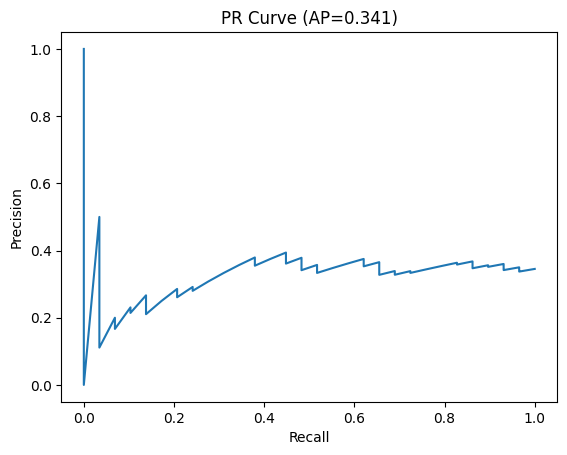

Bootstrapped ROC AUC mean=0.485, 95% CI=(0.356, 0.612)


In [6]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score, roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

# Assuming y_test, y_pred, y_proba already defined
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Precision-Recall
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
ap = average_precision_score(y_test, y_proba)
plt.figure()
plt.plot(recall, precision)
plt.title(f'PR Curve (AP={ap:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# Bootstrapped AUC
rng = np.random.default_rng(42)
n_boot = 1000
auc_boot = []
for _ in range(n_boot):
    idx = rng.integers(0, len(y_test), len(y_test))
    auc_boot.append(roc_auc_score(y_test.iloc[idx], y_proba[idx]))
auc_boot = np.array(auc_boot)
ci_lower, ci_upper = np.percentile(auc_boot, [2.5, 97.5])
print(f"Bootstrapped ROC AUC mean={auc_boot.mean():.3f}, 95% CI=({ci_lower:.3f}, {ci_upper:.3f})")

In [6]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score
import numpy as np

pipe = Pipeline([
    ('sel', SelectKBest(score_func=f_classif)),  # simple, leakage-safe filter
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(penalty='elasticnet', solver='saga',
                               max_iter=10000, class_weight='balanced'))
])

param_grid = {
    'sel__k': [50, 100, 200, 500, 1000],
    'clf__C': np.logspace(-3, 2, 8),
    'clf__l1_ratio': [0.1, 0.5, 0.9],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(pipe, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, refit=True)
gs.fit(X_train, y_train)

print("Best params:", gs.best_params_)
y_pred = gs.predict(X_test)
y_proba = gs.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("PR AUC:", average_precision_score(y_test, y_proba))

Best params: {'clf__C': 3.7275937203149416, 'clf__l1_ratio': 0.5, 'sel__k': 50}
              precision    recall  f1-score   support

         0.0       0.66      0.67      0.67        55
         1.0       0.36      0.34      0.35        29

    accuracy                           0.56        84
   macro avg       0.51      0.51      0.51        84
weighted avg       0.56      0.56      0.56        84

ROC AUC: 0.5197492163009405
PR AUC: 0.3856646990193783


In [8]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score

# Assume `data` is your original DataFrame as shown, with an 'ID_REF' column
df = df_plus_rows.copy()
df = df.set_index('ID_REF')

# Extract metadata rows
# Age
age = pd.to_numeric(df.loc['age'], errors='coerce')

# AD label (yes/no -> 1/0)
y_raw = df.loc['AD'].astype(str).str.lower().str.strip()
y = y_raw.map({'yes': 1, 'no': 0})
if y.isna().any():
    raise ValueError("Found labels other than 'yes'/'no'. Please map them explicitly.")

# Expression matrix (drop metadata rows) and transpose to samples x genes
expr = df.drop(index=['age', 'AD'], errors='ignore')
X_all = expr.T  # samples as rows, genes as columns

# Add age as a covariate
X_all = X_all.join(age.rename('age'))

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y, test_size=0.25, random_state=42, stratify=y
)

# Drop genes with >20% missing, computed on TRAIN ONLY to avoid leakage
missing_threshold = int(0.2 * X_train.shape[0])
gene_cols = [c for c in X_train.columns if c != 'age']
keep_genes = [c for c in gene_cols if X_train[c].isna().sum() <= missing_threshold]

X_train = X_train[keep_genes + ['age']].copy()
X_test  = X_test[keep_genes + ['age']].copy()

# Build a column-wise pipeline: impute/scale/select for genes; impute/scale for age
from sklearn.pipeline import Pipeline as SKPipeline

preprocessor = ColumnTransformer(
    transformers=[
        ('genes', SKPipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler(with_mean=True)),
            ('select', SelectKBest(score_func=f_classif, k=50))  # k will be tuned
        ]), keep_genes),
        ('age', SKPipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler(with_mean=True))
        ]), ['age'])
    ],
    remainder='drop'
)

clf = LogisticRegression(
    penalty='elasticnet', solver='saga', class_weight='balanced', max_iter=10000
)

pipe = Pipeline(steps=[
    ('prep', preprocessor),
    ('clf', clf)
])

param_grid = {
    'prep__genes__select__k': [50, 100, 200],
    'clf__C': np.logspace(-3, 2, 8),
    'clf__l1_ratio': [0.1, 0.5, 0.9],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
gs = GridSearchCV(pipe, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, refit=True)
gs.fit(X_train, y_train)

print("Best params:", gs.best_params_)
y_pred = gs.predict(X_test)
y_proba = gs.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))
print("PR AUC:", average_precision_score(y_test, y_proba))

Best params: {'clf__C': 19.306977288832496, 'clf__l1_ratio': 0.1, 'prep__genes__select__k': 50}
              precision    recall  f1-score   support

           0       0.67      0.69      0.68        55
           1       0.37      0.34      0.36        29

    accuracy                           0.57        84
   macro avg       0.52      0.52      0.52        84
weighted avg       0.56      0.57      0.57        84

ROC AUC: 0.5191222570532916
PR AUC: 0.3833726281609464


In [ ]:
from sklearn.model_selection import StratifiedKFold
from collections import Counter

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
selected_counter = Counter()

for train_idx, test_idx in cv.split(X, y):
    pipeline.fit(X.iloc[train_idx], y.iloc[train_idx])
    clf = pipeline.named_steps['clf']
    # Assuming logistic with L1
    coefs = clf.coef_[0]
    feature_mask = pipeline.named_steps['var'].get_support()
    feature_names = X.columns[feature_mask]
    nonzero = [feature_names[i] for i, w in enumerate(coefs) if w != 0]
    selected_counter.update(nonzero)

print("Top recurring features:")
for feat, freq in selected_counter.most_common(20):
    print(f"{feat}: in {freq} folds")

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

pipeline = Pipeline([
    ('var', VarianceThreshold(threshold=0.0)),  # remove zero-variance genes
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(penalty='l1', solver='saga', max_iter=5000, class_weight='balanced'))
])

X_no_age = X.drop(columns=['age'])
cv_auc_no_age = cross_val_score(pipeline, X_no_age, y, cv=5, scoring='roc_auc')
print("CV AUC without age:", cv_auc_no_age.mean())